This example illustrates how to compute inclusive and air-shower muons
---------------------------------------------------------------------------------

Part of the ingredients is a modification function, which in principle, can have an arbitrary number of parameters.
We start with a simple one, just a linear up-/down-scaling, using one parameter for each particle species.

The particles, which we try to rescale are $\pi^+$, $\pi^-$, K$^+$ and K$^-$. We will fit the muon spectrum
in all accesible zenith bins and the muon charge ratio.

Only protons shall be modified, since particle production by neutrons will be adjusted according
to isospin symmetries.

In [1]:
#basic imports and jupyter setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
#path to MCEq (it makes sense to put it in the same base directory as this project)
sys.path.append('../MCEq')
os.chdir('..')

#import solver related modules
from MCEq.core import MCEqRun
from mceq_config import config
#import primary model choices
import CRFluxModels as pm

In [2]:
import matplotlib as mpl

mpl.rc('font', family='serif', serif=['Times'])
mpl.rc('text', usetex=True)
mpl.rc('legend', frameon=False, numpoints=1,fontsize='medium')
mpl.rc('figure', figsize=(6,4))
mpl.rc('errorbar', capsize=0)
mpl.rc('lines', markersize=6)
mpl.rc('markers', fillstyle='full')

mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.minor.size'] = 2
mpl.rcParams['xtick.minor.size'] = 2
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.top'] = True

In [3]:
config['FP_precision'] = 64
config['kernel_config'] = 'MKL'
# Speed-up of computation. The precision loss from these options is small ~2%
config["hybrid_crossover"] = 0.5
config["vetos"]["allowed_projectiles"] = [2212, 2112, 211, 321, 130]
# cache of atmospheric profiles saves 3-4 seconds for each zenith bins and it needs
# should be used. If used in parallel computations, it has to be complete, otherwise
# multiple nodes will try to write to the same time concurrently.
config["use_atm_cache"] = True
# Use isospin symmetries to derive neutron modifications from protons
config["use_isospin_sym"] = True

In [4]:
mceq_run = MCEqRun(
# Choose the best interaction mode (we can repeat the fit for SIBYLL 2.1 for consistency as well)
interaction_model='SIBYLL2.3',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model=(pm.HillasGaisser2012, 'H3a'),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=16.,
#expand the rest of the options from mceq_config.py
**config
)

DecayYields::_load(): Warning: no decay distributions for 2112 found.
DecayYields::_load(): Warning: no decay distributions for -2112 found.

Hadrons and stable particles:

"gamma", "p", "p-bar", "n", "n-bar"

Mixed:

"pi+", "pi-", "K0L", "K-", "K+", "Lambda0", "Lambda0-bar", "Xi0-bar", 
"Xi0", "K0S", "Xi-", "Xi--bar", "Sigma-", "Sigma--bar", "Sigma+", "Sigma+-bar", 
"Omega-", "Omega--bar", "D-", "D+", "Ds-", "Ds+", "D0-bar", "D0", 
"XiC+", "XiC+-bar", "tau-", "tau+", "LambdaC+", "LambdaC+-bar", "XiC0", "XiC0-bar", 
"OmegaC0", "OmegaC0-bar", "pi0"

Resonances:

"eta", "Sigma0", "Sigma0-bar", "D*-", "D*+", "eta*", "jpsi", "phi", 
"SigmaC0", "SigmaC0-bar", "SigmaC+", "SigmaC+-bar", "SigmaC++", "SigmaC++-bar", "omega", "Xi*0", 
"Xi*0-bar", "Xi*-", "Xi*--bar", "SigmaC*0", "SigmaC*0-bar", "SigmaC*++", "SigmaC*++-bar", "SigmaC*+", 
"SigmaC*+-bar", "K*0-bar", "K*0", "K*-", "K*+", "Sigma*+", "Sigma*+-bar", "Sigma*0", 
"Sigma*0-bar", "Sigma*-", "Sigma*--bar", "etaC", "rho0", "rho+", "rho-", "De

In [6]:
# This is the simplest modification function for inclusive secondary particle distributions

# Particle production matrices will be multiplied elementwise
def mod_linear(xmat, e_grid, a, *args):
    return (1. + a)*np.ones_like(xmat)

# Here is a more complete modification 'value' as a scale factor.
# The phase-space patch is defined by minimum and maximum x_Lab values (minx, maxx)
# and the lab energy range (mine, maxe)

def phase_space_mod(xmat, egrid, value, minx, maxx, mine, maxe, 
                    energy_dependent_scaling=False):
    """A more complete modification function for secondary particle production.
    
    The variable 'value' is a scale factor. The phase-space patch is defined by 
    minimum and maximum x_Lab values (minx, maxx) and the lab energy range of
    the projectile nucleon (mine, maxe).
    """
    
    print "phase_space_mod():", value, (minx, maxx), (mine, maxe)
    
    # If the scale/fudge factor has a (primary/projectile-)energy dependence
    u = lambda E: 0.122*np.log10(E/500.)

    #Create and 1-valued modification matrix 
    modmat = np.ones_like(xmat)
    
    # No lower-triangular factors involved (energy conservation, E_sec > E_prim)
    modmat[np.tril_indices(xmat.shape[0],-1)] = 0.
    
    # Select energy range 
    eidcs = np.where((mine < egrid) & (egrid <= maxe))[0]
    for eidx in eidcs:
        xsel = np.where((xmat[:eidx + 1,eidx] >= minx) & 
                        (xmat[:eidx + 1,eidx] <= maxx))[0]
        
        if not np.any(xsel): continue
        
        if energy_dependent_scaling:
            modmat[xsel,eidx] *= (1 + value + u(egrid[eidx]))
        else:
            modmat[xsel,eidx] *= (1 + value)
                    
    return modmat

In [7]:
def apply_mod(fac_pi_pl, fac_pi_mi, fac_k_pl, fac_k_mi):
    """A function to modify production for the most important particles
    simultaneuosly.
    """
    # Delay re-initialization until all modifications are set
    r = mceq_run.set_mod_pprod(2212,  211, mod_linear, (fac_pi_pl,), delay_init=True)
    r += mceq_run.set_mod_pprod(2212, -211, mod_linear, (fac_pi_mi,), delay_init=True)
    r += mceq_run.set_mod_pprod(2212,  321, mod_linear, (fac_k_pl,), delay_init=True)
    r += mceq_run.set_mod_pprod(2212, -321, mod_linear, (fac_k_mi,), delay_init=True)
    if r > 0:
        mceq_run._init_default_matrices(skip_D_matrix=True)


flux = {}
ratio = {}

# This is a good angle for L3+c and Bess TeV (at the same time)
mceq_run.set_theta_deg(16.)



MCEqRun::set_theta_deg():  16.0
Theta selection correponds to cached value, skipping calc.


Below is an example how to compute a central 'original' prediction and then one with some modification factors applied.

In [8]:
mag = 3.

tot_mu, pi_mu, k_mu= {}, {}, {}

e_grid = mceq_run.y.e_grid

mod_0 = (0.0,0.0,0.0,0.0)
apply_mod(*mod_0)
mceq_run.y.print_mod_pprod()
mceq_run.solve()
tot_mu[mod_0] = np.vstack([mceq_run.get_solution('total_mu+', mag),mceq_run.get_solution('total_mu-', mag)])
pi_mu[mod_0] = np.vstack([mceq_run.get_solution('pi_mu+', mag),mceq_run.get_solution('pi_mu-', mag)])
k_mu[mod_0] = np.vstack([mceq_run.get_solution('k_mu+', mag),mceq_run.get_solution('k_mu-', mag)])

# pi+, pi-, K+, K- mod function arguments
mod_1 = (0.15,0.15,-0.25,0.00)
apply_mod(*mod_1)
mceq_run.y.print_mod_pprod()
mceq_run.solve()
tot_mu[mod_1] = np.vstack([mceq_run.get_solution('total_mu+', mag),mceq_run.get_solution('total_mu-', mag)])
pi_mu[mod_1] = np.vstack([mceq_run.get_solution('pi_mu+', mag),mceq_run.get_solution('pi_mu-', mag)])
k_mu[mod_1] = np.vstack([mceq_run.get_solution('k_mu+', mag),mceq_run.get_solution('k_mu-', mag)])


InteractionYields::set_mod_pprod(): modifying modify particle production matrix of 2212/211.
InteractionYields::init_mod_matrix(): mod_linear (0.0,)
InteractionYields::set_mod_pprod(): modifying modify particle production matrix of 2212/-211.
InteractionYields::init_mod_matrix(): mod_linear (0.0,)
InteractionYields::set_mod_pprod(): modifying modify particle production matrix of 2212/321.
InteractionYields::init_mod_matrix(): mod_linear (0.0,)
InteractionYields::init_mod_matrix(): mod_linear (0.0,)
InteractionYields::set_mod_pprod(): modifying modify particle production matrix of 2212/-321.
InteractionYields::init_mod_matrix(): mod_linear (0.0,)
InteractionYields::init_mod_matrix(): mod_linear (0.0,)
MCEqRun::_init_default_matrices():Start filling matrices. Skip_D_matrix = True
MCEqRun::_convert_to_sparse():Converting to sparse (CSR) matrix format.
C Matrix info:
    density    : 2.05%
    shape      : 7216 x 7216
    nnz        : 1064892
D Matrix info:
    density    : 1.01%
    shape

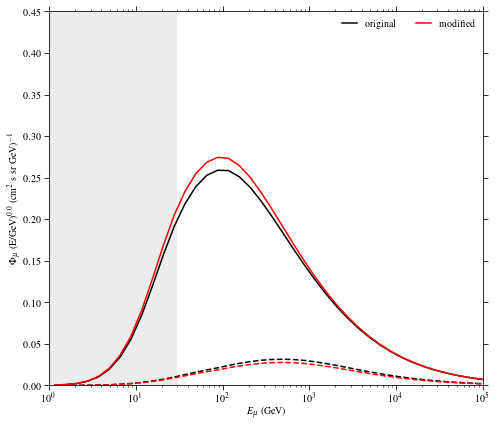

In [18]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

sel = np.where(e_grid > 1.)
ax.semilogx(e_grid[sel], np.sum(tot_mu[mod_0],axis=0)[sel], 
            label='original', color='k')
ax.semilogx(e_grid[sel], np.sum(k_mu[mod_0],axis=0)[sel], 
            color='k',ls='--')
ax.semilogx(e_grid[sel], np.sum(tot_mu[mod_1],axis=0)[sel], 
            label='modified', color='r')
ax.semilogx(e_grid[sel], np.sum(k_mu[mod_1],axis=0)[sel], 
            color='r',ls='--')

ax.fill_between((1,30.),(0.45,0.45),color='grey',alpha=0.15,lw=0.)
ax.set_ylabel(r"$\Phi_\mu$ (E/GeV)$^{" + str(mag) + "}$ (cm$^{2}$ s sr GeV)$^{-1}$")
ax.set_xlim(1,1e5)
ax.set_ylim(0,0.45)
ax.legend(ncol=2)

plt.xlabel(r"$E_{\mu}$ (GeV)")

plt.tight_layout()
# nbu.save('vert_muons_' + model_str)

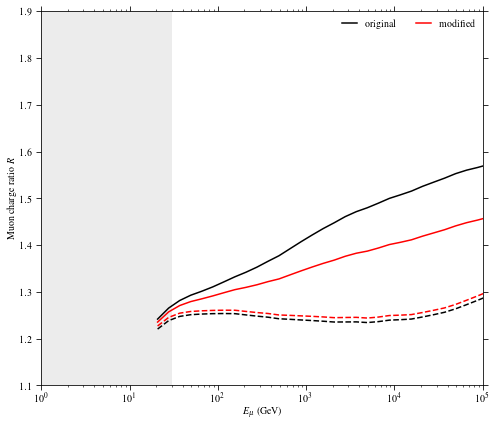

In [12]:
fig, ax = plt.subplots(1,1,figsize=(7,6))

ax.semilogx(e_grid[sel], (tot_mu[mod_0][0]/tot_mu[mod_0][1])[sel], 
            label='original', color='k')
ax.semilogx(e_grid[sel], (pi_mu[mod_0][0]/pi_mu[mod_0][1])[sel], 
            ls='--', color='k')
ax.semilogx(e_grid[sel], (tot_mu[mod_1][0]/tot_mu[mod_1][1])[sel], 
            label='modified', color='r')
ax.semilogx(e_grid[sel], (pi_mu[mod_1][0]/pi_mu[mod_1][1])[sel], 
            ls='--', color='r')

ax.fill_between((1,30.),(5.,5.),color='grey',alpha=0.15,lw=0.)
ax.set_ylabel(r"Muon charge ratio $R$")
ax.set_xlim(1,1e5)
ax.set_ylim(1.1,1.9)
ax.legend(ncol=2)

plt.xlabel(r"$E_{\mu}$ (GeV)")
plt.tight_layout()
# nbu.save('vert_muons_' + model_str)

The same exercise for muon spectra in air-showers using a more complex modification
------------------------------------------------------------------------------------------------

First we will compute the original muon spectrum, using an unmodified interaction model
and then we will modify particle production in an energy range similar that of the SMOG/LHCb.

In [13]:
mceq_run.set_single_primary_particle(1e6, 14) #proton shower at 1 PeV/nucleus

# Don't multiply spectrum with E**mag
mag = 0.

mceq_run.unset_mod_pprod()
mceq_run.y.print_mod_pprod()
mceq_run.solve()
mu_yield_default = np.vstack([mceq_run.get_solution('total_mu+', mag),mceq_run.get_solution('total_mu-', mag)])
mupl_matrix = mceq_run.y.get_y_matrix(2212,211)

MCEqRun::set_single_primary_particle(): corsika_id=14, particle energy=1e+06 GeV
MCEqRununset_mod_pprod(): modifications removed
MCEqRun::_init_default_matrices():Start filling matrices. Skip_D_matrix = True
MCEqRun::_convert_to_sparse():Converting to sparse (CSR) matrix format.
C Matrix info:
    density    : 2.05%
    shape      : 7216 x 7216
    nnz        : 1064892
D Matrix info:
    density    : 1.01%
    shape      : 7216 x 7216
    nnz        : 523616
MCEqRun::_init_default_matrices():Done filling matrices.
MCEqRun::_forward_euler(): Solver will perform 539 integration steps.
Performance:   1.60ms/iteration

MCEqRun::_forward_euler(): time elapsed during integration: 0.863515853882 sec


In [15]:
mceq_run.set_single_primary_particle(1e6, 14) #Proton shower at 1 PeV/nucleus

# Increase pion production in proton and neutron interactions by 30% in the
# x_L interval 1e-9 to 1e-1 and in the projectile energy range 900. GeV to 7 TeV

mceq_run.set_mod_pprod(2212, 211, phase_space_mod, (0.5, 1e-9,1e-1,900.,7000.))
mceq_run.set_mod_pprod(2212, -211, phase_space_mod, (0.5, 1e-9,1e-1,900.,7000.))
mceq_run._init_default_matrices(skip_D_matrix=True)

# See what's set
mceq_run.y.print_mod_pprod()
mceq_run.solve()

mu_yield_modified = np.vstack([mceq_run.get_solution('total_mu+', mag),mceq_run.get_solution('total_mu-', mag)])
mupl_matrix_mod = mceq_run.y.get_y_matrix(2212,211)

MCEqRun::set_single_primary_particle(): corsika_id=14, particle energy=1e+06 GeV
InteractionYields::set_mod_pprod(): modifying modify particle production matrix of 2212/211.
InteractionYields::init_mod_matrix(): phase_space_mod (0.5, 1e-09, 0.1, 900.0, 7000.0)
phase_space_mod(): 0.5 (1e-09, 0.1) (900.0, 7000.0)
InteractionYields::set_mod_pprod(): modifying modify particle production matrix of 2212/-211.
InteractionYields::init_mod_matrix(): phase_space_mod (0.5, 1e-09, 0.1, 900.0, 7000.0)
phase_space_mod(): 0.5 (1e-09, 0.1) (900.0, 7000.0)
MCEqRun::_init_default_matrices():Start filling matrices. Skip_D_matrix = True
MCEqRun::_convert_to_sparse():Converting to sparse (CSR) matrix format.
C Matrix info:
    density    : 2.05%
    shape      : 7216 x 7216
    nnz        : 1064892
D Matrix info:
    density    : 1.01%
    shape      : 7216 x 7216
    nnz        : 523616
MCEqRun::_init_default_matrices():Done filling matrices.
0: 2112 -> -211, func: isospin, arg: (0.5, 1e-09, 0.1, 900.0, 7

at projectile energy 2766.82568292 GeV


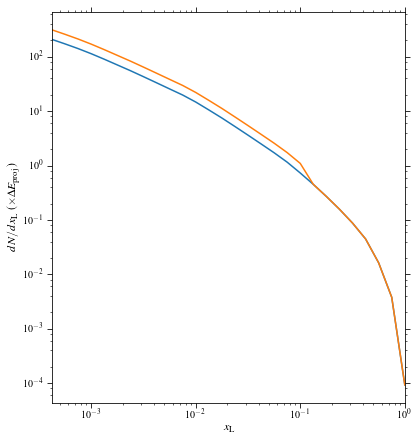

In [16]:
fig, ax = plt.subplots(1,1, sharex=True, figsize=(7,7))
proj_eidx = 27 
print 'at projectile energy', e_grid[proj_eidx], 'GeV'
xgrid = e_grid[:proj_eidx + 1]/e_grid[proj_eidx]
plt.loglog(xgrid, mupl_matrix[:proj_eidx + 1,proj_eidx],label='original')
plt.loglog(xgrid, mupl_matrix_mod[:proj_eidx + 1,proj_eidx],label='modified')
plt.xlabel(r'$x_{\rm L}$',fontsize='large')
plt.ylabel(r'$dN/dx_{\rm L}$ ($\times \Delta E_{\rm proj}$)',fontsize='large')

/Users/hdembins/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in divide
  import sys


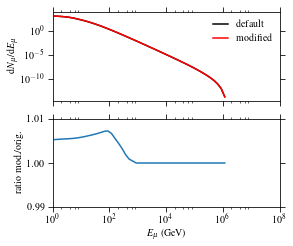

In [17]:
fig, ax = plt.subplots(2,1, sharex=True, figsize=(4.5,3.5))

ax[0].loglog(e_grid, np.sum(mu_yield_default, axis=0), color='k', label='default')
ax[0].loglog(e_grid, np.sum(mu_yield_modified, axis=0), color='r', label='modified')
ax[0].set_ylabel(r'd$N_\mu$/d$E_\mu$')
ax[0].legend()
ax[1].semilogx(e_grid, np.sum(mu_yield_modified, axis=0)/np.sum(mu_yield_default, axis=0), 
             label='ratio')

ax[1].set_ylim(0.99, 1.01)
ax[1].set_xlim(1.,100e6)

ax[1].set_ylabel(r'ratio mod./orig.')
ax[1].set_xlabel(r'$E_\mu$ (GeV)')
